## Use Apache Spark

In [15]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

StatementMeta(, 8f0356e7-f7fb-4904-ad25-41408f79ed6d, 17, Finished, Available, Finished)

### Infer Schema

In [5]:
df = spark.read.load(
    'Files/flights.csv',
    format='csv',
    header=True
)
display(df.limit(5))

StatementMeta(, 8f0356e7-f7fb-4904-ad25-41408f79ed6d, 7, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 5fb12ab5-5674-4ce9-89c1-6c07ab0e56ad)

### Specify Schema

In [3]:
from pyspark.sql.types import *
from pyspark.sql.functions import *

dataSchema = StructType([
    StructField('Airline', StringType()),
    StructField('Date_of_Journey', DateType()),
    StructField('Source', StringType()),
    StructField('Destination', StringType()),
    StructField('Price', IntegerType())
])

df = spark.read.load(
    'Files/flights.csv',
    format='csv',
    schema=dataSchema,
    header=True
)

display(df.limit(5))

StatementMeta(, 8f0356e7-f7fb-4904-ad25-41408f79ed6d, 5, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 78553f3d-73ac-49c0-a056-99d8a92a274f)

### Filter and Sort Data

In [6]:
pricelist_df = df.select(
    'Airline', 'Price'
).orderBy('Price', ascending=False)
display(pricelist_df.limit(10))

StatementMeta(, 8f0356e7-f7fb-4904-ad25-41408f79ed6d, 8, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 70434131-990e-40db-b9c6-7dcf9a24bdf0)

### Chain methods together

In [7]:
flight_df = df.select(
    'Airline', 'Price'
).where((df['Source']=='Banglore') & (df['Destination']=='New Delhi'))
display(flight_df.limit(20))

StatementMeta(, 8f0356e7-f7fb-4904-ad25-41408f79ed6d, 9, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 64919843-5bde-4a75-a4a3-91ad11e3adda)

### Group and aggregate data

In [8]:
counts_df = df.select('Airline', 'Price').groupBy('Airline', 'Price').count()
display(counts_df.limit(20))

StatementMeta(, 8f0356e7-f7fb-4904-ad25-41408f79ed6d, 10, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, a3f863a1-9a28-4903-9ac1-204b36feeb4e)

### Convert data type

In [16]:
# Convert Date_of_Journey to date
df = df.withColumn("Date_of_Journey", to_date(col("Date_of_Journey"), "dd/MM/yyyy"))

# Convert Price to integer
df = df.withColumn("Price", col("Price").cast("int"))

display(df.limit(10))

StatementMeta(, 8f0356e7-f7fb-4904-ad25-41408f79ed6d, 18, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, e5bed56a-fe75-4dfe-b791-243c85d3a658)

### Save dataframe for further analysis

In [18]:
df.write.format("delta").mode('overwrite').saveAsTable("flight_table")

StatementMeta(, 8f0356e7-f7fb-4904-ad25-41408f79ed6d, 20, Finished, Available, Finished)

### Visualize data

In [19]:
%%sql
SELECT * FROM flight_table

StatementMeta(, 8f0356e7-f7fb-4904-ad25-41408f79ed6d, 21, Finished, Available, Finished)

<Spark SQL result set with 1000 rows and 11 fields>

StatementMeta(, 8f0356e7-f7fb-4904-ad25-41408f79ed6d, 22, Finished, Available, Finished)

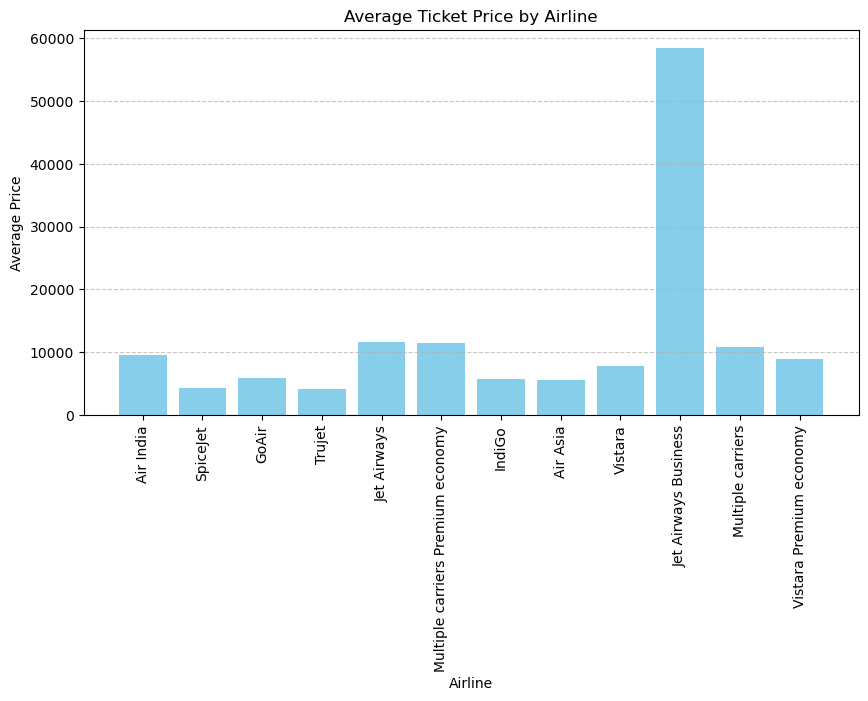

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert Spark DataFrame to Pandas DataFrame
pdf = df.select("Airline", "Price").groupBy("Airline").avg("Price").toPandas()

# Plot the data
plt.figure(figsize=(10, 5))
plt.bar(pdf["Airline"], pdf["avg(Price)"], color='skyblue')

# Formatting
plt.xlabel("Airline")
plt.ylabel("Average Price")
plt.title("Average Ticket Price by Airline")
plt.xticks(rotation=90)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()

## Delta Lake Tables

### Create Delta tables

save as managed tables and external tables

In [23]:
# Load a file into a dataframe
df = spark.read.load('Files/flights.csv', format='csv', header=True)

# Save a dataframe as a managed table
df.write.mode('overwrite').format("delta").saveAsTable("flight_managed_table")

# Save a dataframe in delta format in an explicit path
df.write.mode('overwrite').format("delta").save("Files/flight_explicit_table")

# Save a dataframe as a external table
df.write.mode('overwrite').format("delta").saveAsTable('flight_external_table', path="Files/flight_external_table")

StatementMeta(, 8f0356e7-f7fb-4904-ad25-41408f79ed6d, 25, Finished, Available, Finished)

Use spark SQL

In [21]:
%%sql

CREATE TABLE flight_order
(
    Orderid INT NOT NULL,
    Airline STRING,
    OrderDate TIMESTAMP NOT NULL,
    CustomerName STRING,
    Price FLOAT NOT NULL
)
USING DELTA

StatementMeta(, 8f0356e7-f7fb-4904-ad25-41408f79ed6d, 23, Finished, Available, Finished)

<Spark SQL result set with 0 rows and 0 fields>

Use Spark SQL to embed a SQL statement in PySpark

In [25]:
spark.sql("INSERT INTO flight_managed_table VALUES('Garuda', '2/24/2025', 'Jakarta', 'Medan', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 21344)")
spark.sql("SELECT * FROM flight_managed_table WHERE Airline = 'Garuda'").show()

StatementMeta(, 8f0356e7-f7fb-4904-ad25-41408f79ed6d, 27, Finished, Available, Finished)

+-------+---------------+-------+-----------+-----+--------+------------+--------+-----------+---------------+-----+
|Airline|Date_of_Journey| Source|Destination|Route|Dep_Time|Arrival_Time|Duration|Total_Stops|Additional_Info|Price|
+-------+---------------+-------+-----------+-----+--------+------------+--------+-----------+---------------+-----+
| Garuda|      2/24/2025|Jakarta|      Medan| NULL|    NULL|        NULL|    NULL|       NULL|           NULL|21344|
+-------+---------------+-------+-----------+-----+--------+------------+--------+-----------+---------------+-----+



Native Spark SQL using %%sql magic

In [29]:
%%sql

UPDATE flight_managed_table
SET Price = 12453 WHERE Airline = 'Garuda';
SELECT * FROM flight_managed_table
WHERE Airline = 'Garuda';

StatementMeta(, 8f0356e7-f7fb-4904-ad25-41408f79ed6d, 34, Finished, Available, Finished)

<Spark SQL result set with 1 rows and 1 fields>

<Spark SQL result set with 1 rows and 11 fields>

Use the delta API

In [31]:
from delta.tables import *
from pyspark.sql.functions import *

# Create a DeltaTable object
delta_path = "Files/flight_external_table"
deltaTable = DeltaTable.forPath(spark, delta_path)

# Update the table (reduce price of IndiGo by 10%)
deltaTable.update(
    condition = "Airline == 'IndiGo'",
    set = { "Price": "Price * 0.9" })


StatementMeta(, 8f0356e7-f7fb-4904-ad25-41408f79ed6d, 36, Finished, Available, Finished)

In [32]:
spark.sql("SELECT * FROM delta.`Files/flight_external_table` WHERE Airline = 'IndiGo'").show()

StatementMeta(, 8f0356e7-f7fb-4904-ad25-41408f79ed6d, 37, Finished, Available, Finished)

+-------+---------------+--------+-----------+--------------------+--------+------------+--------+-----------+---------------+-----------------+
|Airline|Date_of_Journey|  Source|Destination|               Route|Dep_Time|Arrival_Time|Duration|Total_Stops|Additional_Info|            Price|
+-------+---------------+--------+-----------+--------------------+--------+------------+--------+-----------+---------------+-----------------+
| IndiGo|     01/03/2019|Banglore|  New Delhi|     BLR ? HYD ? DEL|   16:55|       21:50|  4h 55m|     1 stop|        No Info|           7337.7|
| IndiGo|     01/03/2019|Banglore|  New Delhi|     BLR ? HYD ? DEL|   16:15|       20:35|  4h 20m|     1 stop|        No Info|           7125.3|
| IndiGo|     01/03/2019|Banglore|  New Delhi|     BLR ? HYD ? DEL|   05:15|       10:00|  4h 45m|     1 stop|        No Info|           7257.6|
| IndiGo|      9/03/2019|   Delhi|     Cochin|DEL ? HYD ? MAA ?...|   06:40|       21:20| 14h 40m|    2 stops|        No info|7331